# 环境准备

In [68]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio

下面代码是为了解决绘制图表时内核崩溃的问题

In [69]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 数据准备

加载音频文件，合成4通道立体声

In [70]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
import soundfile as sf
import torch


#合成4通道噪声音频
# 文件路径
noise_files = [
    'InsectSound//noise//mic00_bg.wav',
    'InsectSound//noise//mic01_bg.wav', 
    'InsectSound//noise//mic02_bg.wav', 
    'InsectSound//noise//mic03_bg.wav'
]

# 读取音频文件
data = [sf.read(file)[0] for file in noise_files]  # 假设所有文件具有相同的采样率

# 将数据合并成多通道格式
multichannel_data = np.stack(data, axis=-1)

# 写入新的多通道WAV文件
sf.write('InsectSound/noise/multichannel_output.wav', multichannel_data, samplerate=sf.info(files[0]).samplerate)

# 读取音频文件
audio_file = 'InsectSound/noise/multichannel_output.wav'  # 替换为您的音频文件路径
audio, sr = librosa.load(audio_file, sr=None, mono=False)  # 读取音频文件，保持多声道

# 获取音频的通道数
num_channels = audio.shape[0] if audio.ndim > 1 else 1

# 打印音频的通道数
print("噪声音频的通道数:", num_channels)

#合成4通道虫声音频
insect_sounds = [
    'InsectSound//spk//spk1_mic1.wav', 
    'InsectSound//spk//spk1_mic2.wav', 
    'InsectSound//spk//spk1_mic3.wav', 
    'InsectSound//spk//spk1_mic4.wav'
]

# 读取音频文件
data = [sf.read(file)[0] for file in insect_sounds]  # 假设所有文件具有相同的采样率

# 将数据合并成多通道格式
multichannel_data = np.stack(data, axis=-1)

# 写入新的多通道WAV文件
sf.write('InsectSound/spk/multichannel_output.wav', multichannel_data, samplerate=sf.info(files[0]).samplerate)

# 读取音频文件
audio_file = 'InsectSound/spk/multichannel_output.wav'  # 替换为您的音频文件路径
audio, sr = librosa.load(audio_file, sr=None, mono=False)  # 读取音频文件，保持多声道

# 获取音频的通道数
num_channels = audio.shape[0] if audio.ndim > 1 else 1

# 打印音频的通道数
print("虫声音频的通道数:", num_channels)

噪声音频的通道数: 4
虫声音频的通道数: 4


检查合成音频的波形图

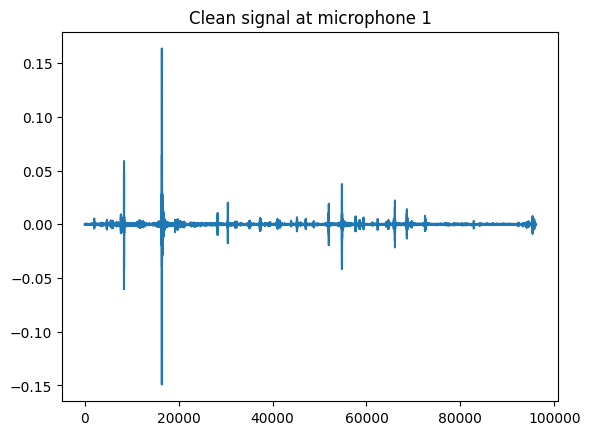

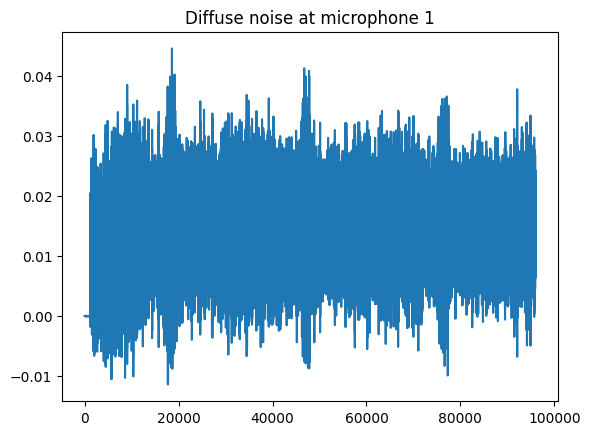

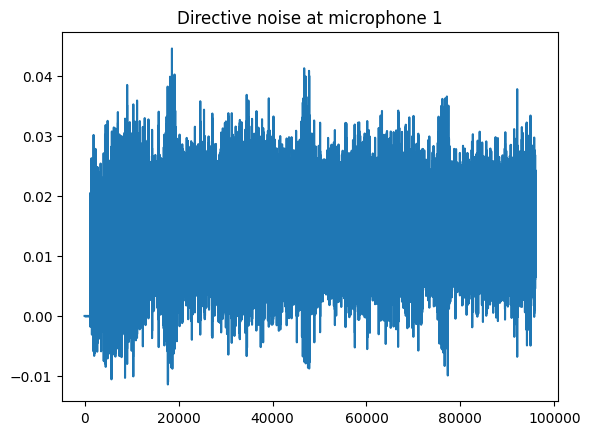

In [71]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio

xs_speech = read_audio('InsectSound/spk/multichannel_output.wav') # [time, channels]
xs_speech = xs_speech.unsqueeze(0) # [batch, time, channels]
xs_noise_diff = read_audio('InsectSound/noise/multichannel_output.wav') # [time, channels]
xs_noise_diff = xs_noise_diff.unsqueeze(0) # [batch, time, channels]
xs_noise_loc = read_audio('InsectSound/noise/multichannel_output.wav') # [time, channels]
xs_noise_loc =  xs_noise_loc.unsqueeze(0) # [batch, time, channels]
fs = 16000 # sampling rate

plt.figure(1)
plt.title('Clean signal at microphone 1')
plt.plot(xs_speech.squeeze()[:,0])
plt.figure(2)
plt.title('Diffuse noise at microphone 1')
plt.plot(xs_noise_diff.squeeze()[:,0])
plt.figure(3)
plt.title('Directive noise at microphone 1')
plt.plot(xs_noise_loc.squeeze(0)[:,0])
plt.show()

我们可以听到干净干净的虫声和噪声

In [72]:
from IPython.display import Audio
Audio(xs_speech.squeeze()[:,0],rate=fs)


接下来生成混合噪声

In [73]:
ss = xs_speech
nn_diff = 0.5 * xs_noise_diff
nn_loc = 0.5 * xs_noise_loc
xs_diffused_noise = ss + nn_diff
xs_localized_noise = ss + nn_loc

绘制混合虫声的波形图

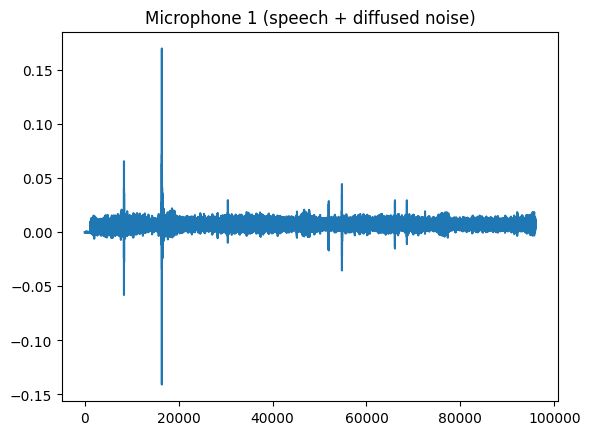

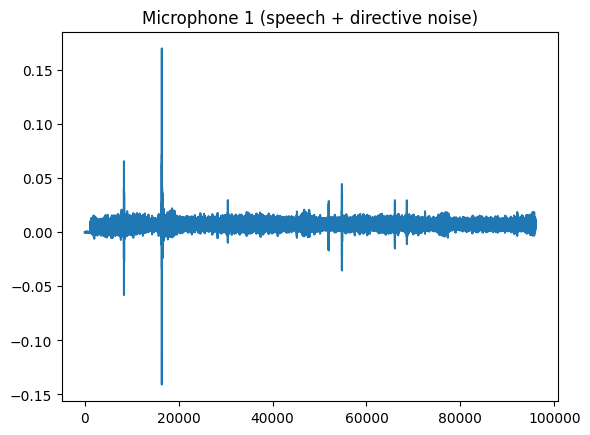

In [74]:
plt.figure(1)
plt.title('Microphone 1 (speech + diffused noise)')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(2)
plt.title('Microphone 1 (speech + directive noise)')
plt.plot(xs_localized_noise.squeeze()[:,0])
plt.show()

播放混合虫声

In [75]:
from IPython.display import Audio
Audio(xs_diffused_noise.squeeze()[:,0],rate=fs)

# 虫声处理

## 带相变的转向响应功率

STFT（短时傅里叶变换）将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 SRP-PHAT 模块将返回到达方向。我们需要提供麦克风阵列的几何形状，在研究中是一个线性阵列，有四个均匀分布的麦克风，直径为 0.1m。系统估计每个 STFT 帧的 DOA。另请注意，由于所有麦克风均位于xy平面上，系统无法区分正z轴和负z轴。

In [76]:
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import SrpPhat

import torch

mics = torch.zeros((4,3), dtype=torch.float)
mics[0,:] = torch.FloatTensor([-0.10, -0.00, +0.00])
mics[1,:] = torch.FloatTensor([-0.05, +0.00, +0.00])
mics[2,:] = torch.FloatTensor([+0.05, +0.00, +0.00])
mics[3,:] = torch.FloatTensor([+0.10, +0.00, +0.00])

stft = STFT(sample_rate=fs)
cov = Covariance()
srpphat = SrpPhat(mics=mics)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
doas = srpphat(XXs)

print(doas)

tensor([[[ 0.0406, -0.0559,  0.9976],
         [ 0.0406, -0.0559,  0.9976],
         [ 0.0406, -0.0559,  0.9976],
         ...,
         [ 0.0406, -0.0559,  0.9976],
         [ 0.0406, -0.0559,  0.9976],
         [ 0.0406, -0.0559,  0.9976]]])


## 多信号分类

In [77]:
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import Music

import torch

mics = torch.zeros((4,3), dtype=torch.float)
mics[0,:] = torch.FloatTensor([-0.10, -0.00, +0.00])
mics[1,:] = torch.FloatTensor([-0.05, +0.00, +0.00])
mics[2,:] = torch.FloatTensor([+0.05, +0.00, +0.00])
mics[3,:] = torch.FloatTensor([+0.10, +0.00, +0.00])

stft = STFT(sample_rate=fs)
cov = Covariance()
music = Music(mics=mics)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
doas = music(XXs)

print(doas)

tensor([[[0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         ...,
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.]]])


## 延迟求和波束成形
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 GCC-PHAT模块将估计每个麦克风之间的到达时间差（TDOA），并使用该TDOA进行延迟和求和。

### 语音因弥漫性噪音而损坏

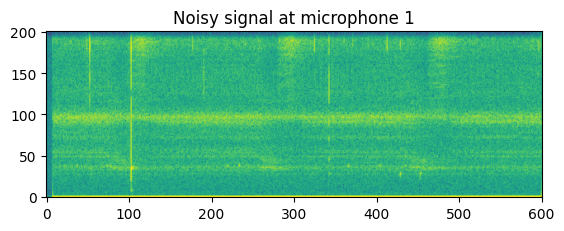

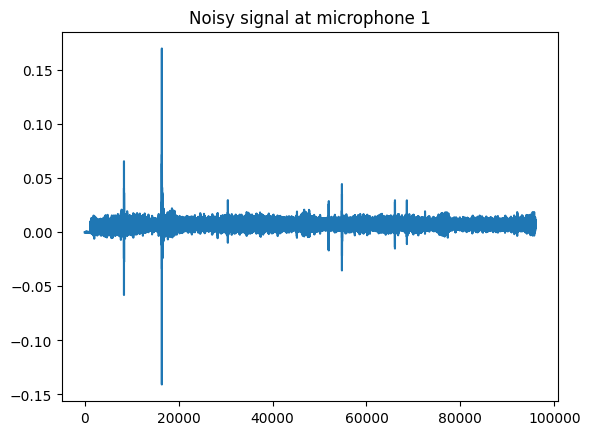

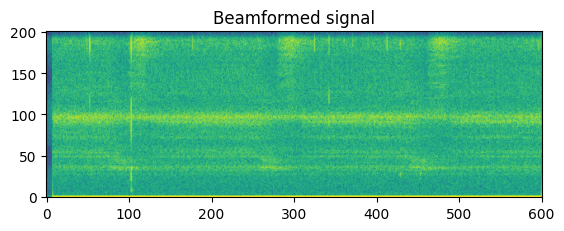

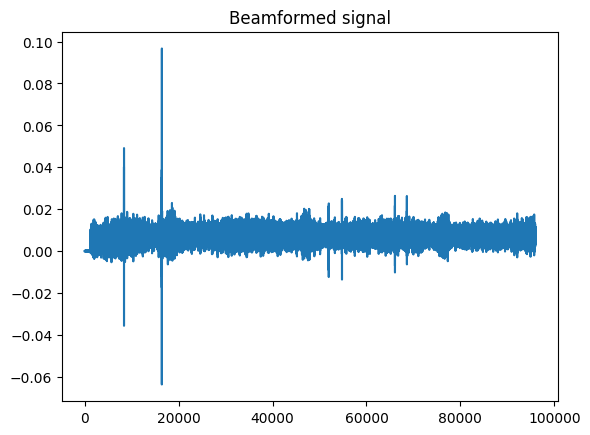

In [78]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import DelaySum

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
delaysum = DelaySum()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
tdoas = gccphat(XXs)
Ys_ds = delaysum(Xs, tdoas)
ys_ds = istft(Ys_ds)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_ds[0,:,:,0,0]**2 + Ys_ds[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_ds.squeeze())
plt.show()

收听波束形成的信号并与噪声信号进行比较

In [79]:
from IPython.display import Audio
Audio(xs_diffused_noise.squeeze()[:,0],rate=fs)

In [80]:
from IPython.display import Audio
Audio(ys_ds.squeeze(),rate=fs)

### 语音因指令性噪音而损坏
当我们有定向噪声时，这会更加棘手，因为 GCC-PHAT 可以从噪声源捕获 TDOA。现在我们简单地假设我们知道 TDOA，但可以应用理想的二进制掩码来区分语音 TDOA 和噪声 TDOA。

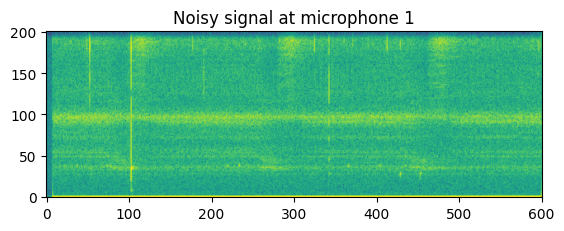

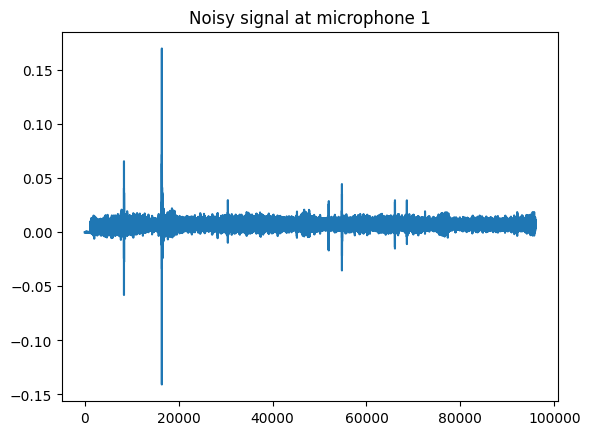

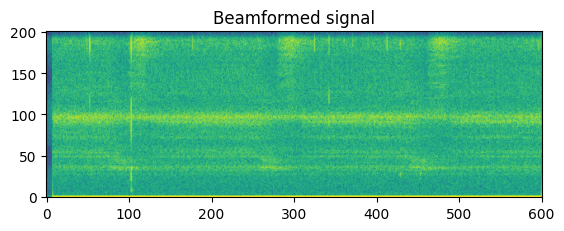

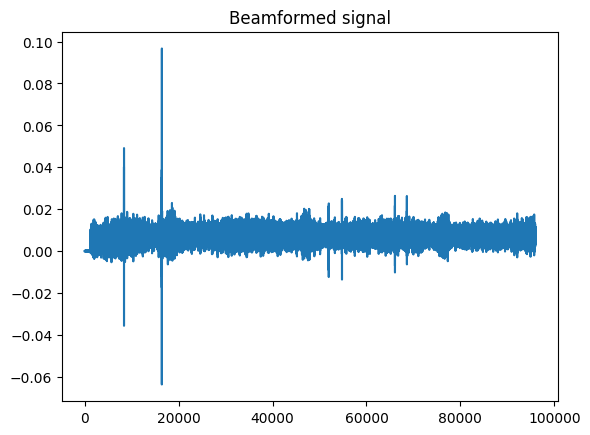

In [81]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import DelaySum

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
delaysum = DelaySum()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
XXs = cov(Xs)
tdoas = gccphat(XXs)

Xs = stft(xs_localized_noise)
XXs = cov(Xs)
Ys_ds = delaysum(Xs, tdoas)
ys_ds = istft(Ys_ds)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_ds[0,:,:,0,0]**2 + Ys_ds[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_ds.squeeze())
plt.show()

In [82]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [83]:
from IPython.display import Audio
Audio(ys_ds.squeeze(),rate=fs)

## 最小方差无失真响应
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。 GCC-PHAT 模块将估计每个麦克风之间的到达时间差 (TDOA)，并使用此 TDOA 执行 MVDR 波束成形。

### 语音因弥漫性噪音而损坏

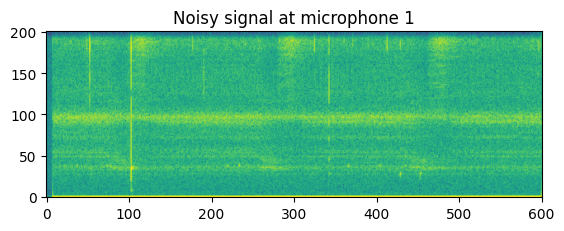

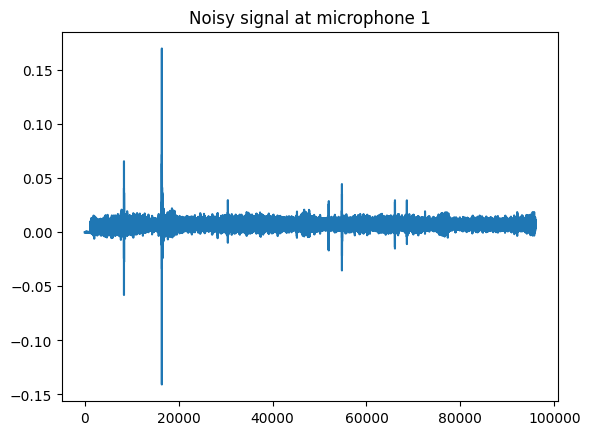

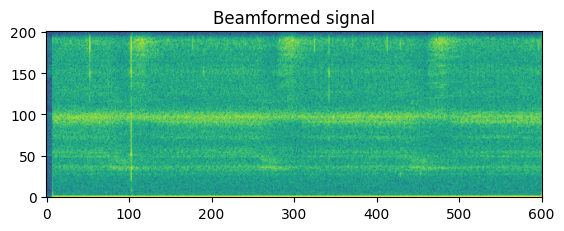

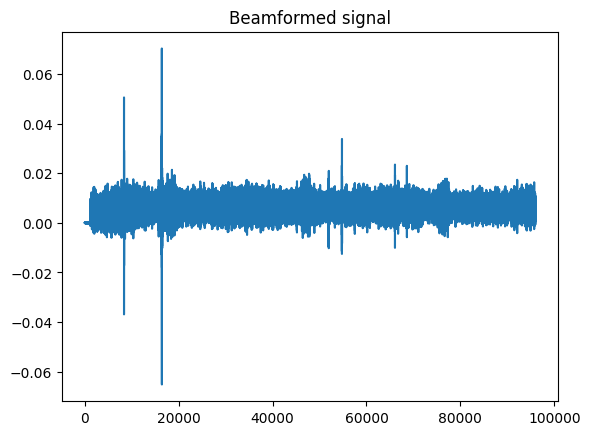

In [84]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import Mvdr

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
mvdr = Mvdr()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
Nn = stft(nn_diff)
NNs = cov(Nn)
XXs = cov(Xs)
tdoas = gccphat(XXs)
Ys_mvdr = mvdr(Xs, NNs, tdoas)
ys_mvdr = istft(Ys_mvdr)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_mvdr[0,:,:,0,0]**2 + Ys_mvdr[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_mvdr.squeeze())
plt.show()

In [85]:
from IPython.display import Audio
Audio(xs_diffused_noise.squeeze()[:,0],rate=fs)

In [86]:
from IPython.display import Audio
Audio(ys_mvdr.squeeze(),rate=fs)

### 语音因指令性噪音而损坏
再次，当我们有定向噪声时，这会更加棘手，因为 GCC-PHAT 可以从噪声源捕获 TDOA。现在我们简单地假设我们知道 TDOA，但可以应用理想的二进制掩码来区分语音 TDOA 和噪声 TDOA。

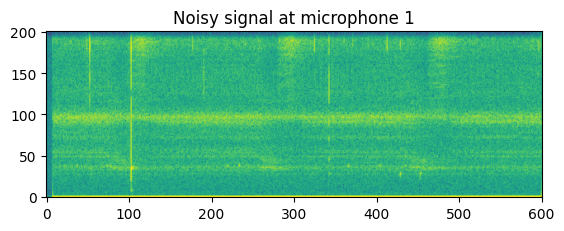

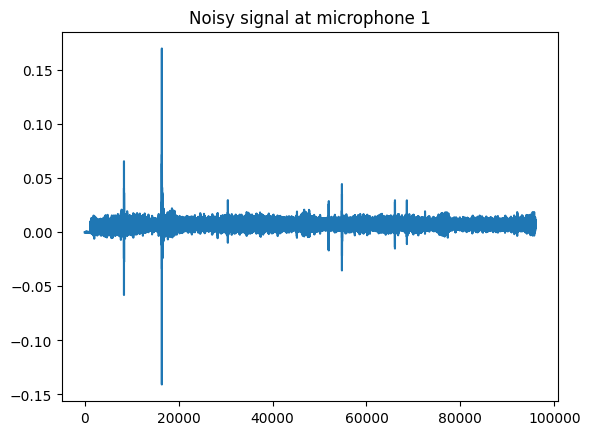

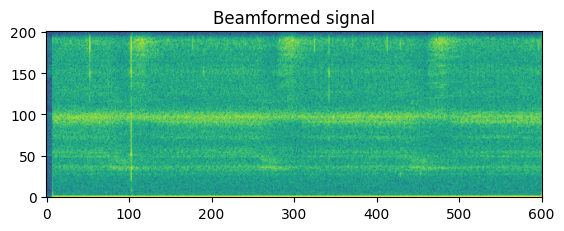

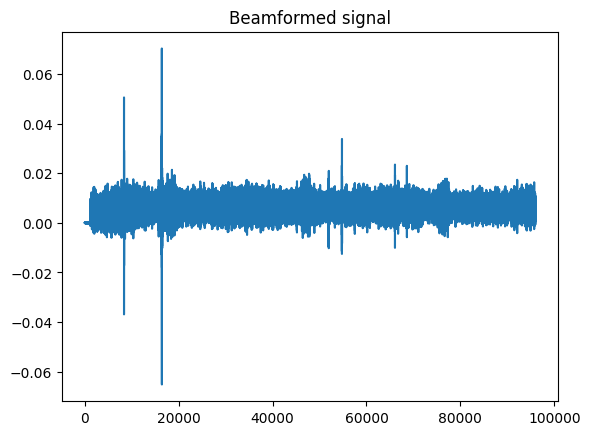

In [87]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import Mvdr

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
mvdr = Mvdr()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
Nn = stft(nn_loc)
XXs = cov(Xs)
NNs = cov(Nn)
tdoas = gccphat(XXs)

Xs = stft(xs_localized_noise)
Ys_mvdr = mvdr(Xs, NNs, tdoas)
ys_mvdr = istft(Ys_mvdr)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_diffused_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_mvdr[0,:,:,0,0]**2 + Ys_mvdr[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_mvdr.squeeze())
plt.show()

In [88]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [89]:
from IPython.display import Audio
Audio(ys_mvdr.squeeze(),rate=fs)

## 广义特征值波束形成
STFT 将在频域中转换信号，然后协方差将计算每个频率仓的协方差矩阵。我们假设我们可以分别计算语音和噪声的协方差矩阵，并将其用于波束成形。可以使用理想的二进制掩码来估计协方差矩阵。

### 语音因弥漫性噪音而损坏

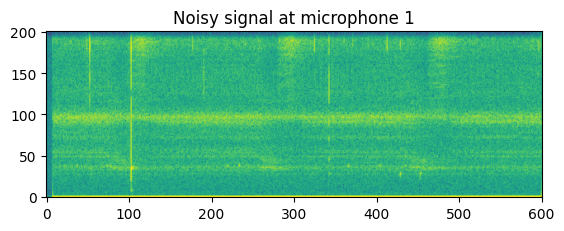

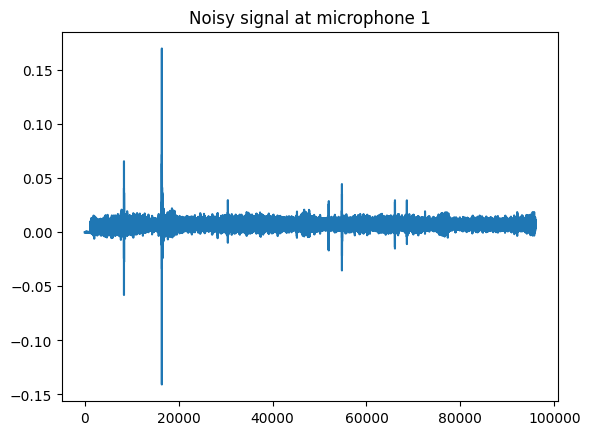

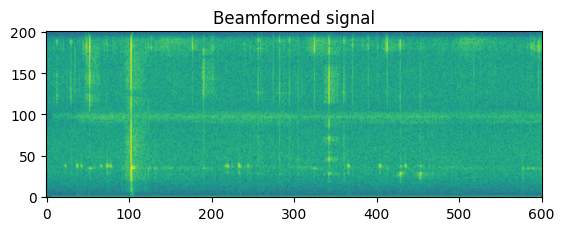

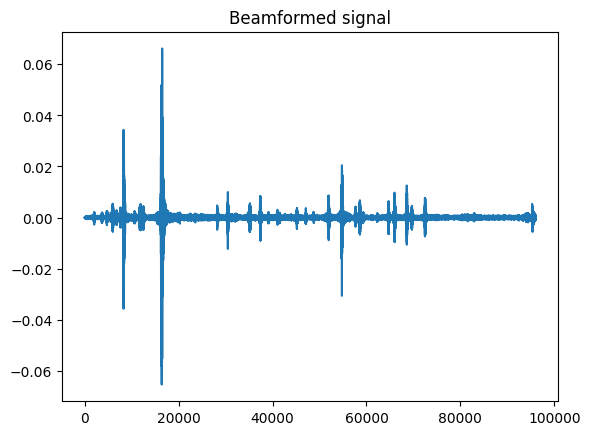

In [90]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import Gev

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
gev = Gev()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_diffused_noise)
Ss = stft(ss)
Nn = stft(nn_diff)
SSs = cov(Ss)
NNs = cov(Nn)
Ys_gev = gev(Xs, SSs, NNs)
ys_gev = istft(Ys_gev)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_localized_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_gev[0,:,:,0,0]**2 + Ys_gev[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_gev.squeeze())
plt.show()

### 语音因指令性噪音而损坏

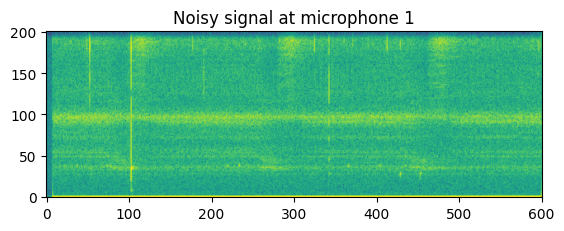

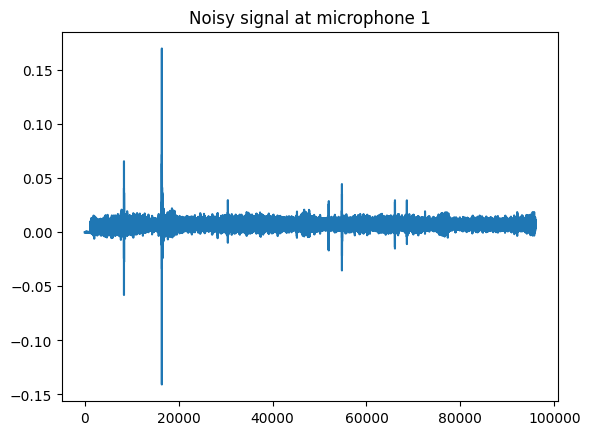

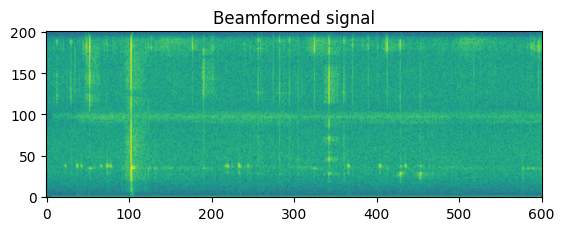

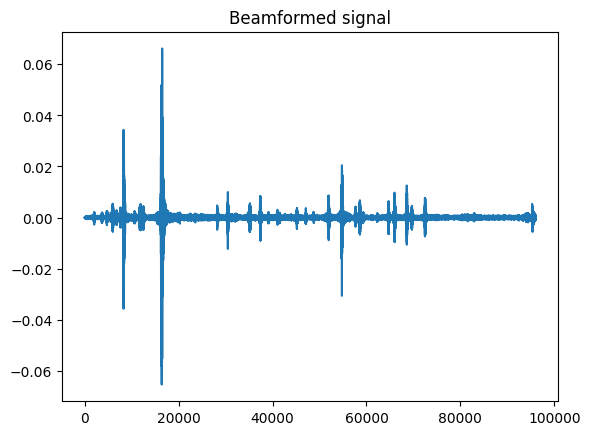

In [91]:
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import Gev

import matplotlib.pyplot as plt
import torch

stft = STFT(sample_rate=fs)
cov = Covariance()
gccphat = GccPhat()
gev = Gev()
istft = ISTFT(sample_rate=fs)

Xs = stft(xs_localized_noise)
Ss = stft(ss)
Nn = stft(nn_loc)
SSs = cov(Ss)
NNs = cov(Nn)
Ys_gev = gev(Xs, SSs, NNs)
ys_gev = istft(Ys_gev)

plt.figure(1)
plt.title('Noisy signal at microphone 1')
plt.imshow(torch.transpose(torch.log(Xs[0,:,:,0,0]**2 + Xs[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(2)
plt.title('Noisy signal at microphone 1')
plt.plot(xs_localized_noise.squeeze()[:,0])
plt.figure(3)
plt.title('Beamformed signal')
plt.imshow(torch.transpose(torch.log(Ys_gev[0,:,:,0,0]**2 + Ys_gev[0,:,:,1,0]**2), 1, 0), origin="lower")
plt.figure(4)
plt.title('Beamformed signal')
plt.plot(ys_gev.squeeze())
plt.show()

In [92]:
from IPython.display import Audio
Audio(xs_localized_noise.squeeze()[:,0],rate=fs)

In [93]:
from IPython.display import Audio
Audio(ys_gev.squeeze(),rate=fs)